In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [36]:
# 讀取完整csv檔
df = pd.read_csv('./finalcsv/finalcsv3s_dropna.csv', index_col=0)
df

,song_name,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_std,chroma_stft_var,chroma_cq_mean,chroma_cq_std,chroma_cq_var,...,perc_mean,perc_std,perc_var,frame_mean,frame_std,frame_var,label,songid,videoname,url
0,blues1-1-0.wav,92.285156,154,51.333333,0.385921,0.329183,0.108361,0.359351,0.287664,0.082751,...,5.932062e-06,0.042748,1.827389e-03,1.532517,0.929153,0.863325,blues,blues1,On the Road (with G Love & Special Sauce and C...,https://www.youtube.com/watch?v=9G51ys_EpVY
1,blues1-1-1.wav,117.453835,259,51.800000,0.406119,0.292756,0.085706,0.529980,0.230604,0.053178,...,7.175754e-05,0.104580,1.093703e-02,1.583055,0.919575,0.845618,blues,blues1,On the Road (with G Love & Special Sauce and C...,https://www.youtube.com/watch?v=9G51ys_EpVY
2,blues1-1-2.wav,123.046875,70,23.333333,0.419712,0.293514,0.086150,0.515283,0.244956,0.060003,...,-7.127864e-05,0.097512,9.508545e-03,1.425447,0.869471,0.755979,blues,blues1,On the Road (with G Love & Special Sauce and C...,https://www.youtube.com/watch?v=9G51ys_EpVY
3,blues1-1-3.wav,123.046875,232,46.400000,0.372463,0.298041,0.088828,0.464383,0.256593,0.065840,...,-1.488557e-04,0.099613,9.922689e-03,1.503834,0.835938,0.698793,blues,blues1,On the Road (with G Love & Special Sauce and C...,https://www.youtube.com/watch?v=9G51ys_EpVY
4,blues1-1-4.wav,117.453835,190,47.500000,0.410708,0.288858,0.083439,0.527301,0.244868,0.059960,...,3.234200e-05,0.098527,9.707515e-03,1.486077,0.863520,0.745667,blues,blues1,On the Road (with G Love & Special Sauce and C...,https://www.youtube.com/watch?v=9G51ys_EpVY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36467,rock9-6-7.wav,89.102909,206,51.500000,0.322178,0.292483,0.085546,0.401523,0.264842,0.070141,...,-1.983460e-04,0.047178,2.225771e-03,1.371525,0.875794,0.767016,rock,rock9,The Joy Formidable - CSTS (Official Music Video),https://www.youtube.com/watch?v=CVJTfcf1mUY
36468,rock9-6-8.wav,161.499023,474,59.250000,0.364285,0.306560,0.093979,0.459289,0.273025,0.074542,...,-8.188963e-05,0.047307,2.237983e-03,1.507749,0.855279,0.731502,rock,rock9,The Joy Formidable - CSTS (Official Music Video),https://www.youtube.com/watch?v=CVJTfcf1mUY
36469,rock9-6-9.wav,103.359375,159,39.750000,0.233333,0.291198,0.084796,0.382516,0.285876,0.081725,...,-8.248456e-05,0.013742,1.888385e-04,1.080889,0.683372,0.466998,rock,rock9,The Joy Formidable - CSTS (Official Music Video),https://www.youtube.com/watch?v=CVJTfcf1mUY
36470,rock9-7-0.wav,89.102909,95,31.666667,0.197100,0.304692,0.092837,0.340628,0.301412,0.090849,...,-1.477586e-06,0.000745,5.544711e-07,1.333857,0.868819,0.754846,rock,rock9,The Joy Formidable - CSTS (Official Music Video),https://www.youtube.com/watch?v=CVJTfcf1mUY


In [37]:
# # 將label字串轉成數字的類別0-9
# df['label']=df['label'].replace(['blues','classical','country','disco','hiphop','jazz','metal','pop'
# ,'reggae','rock'],[0,1,2,3,4,5,6,7,8,9])

In [38]:
# 將song_name欄位丟掉
df = df.drop(['song_name','videoname','url','songid'], axis=1)
# 確定剩下數字資料型態
df.dtypes

tempo               float64
total_beats           int64
average_beats       float64
chroma_stft_mean    float64
chroma_stft_std     float64
                     ...   
perc_var            float64
frame_mean          float64
frame_std           float64
frame_var           float64
label                object
Length: 169, dtype: object

In [39]:
# 分成特徵欄位及預測目標欄位
y = df['label']
X = df.loc[:, df.columns != 'label'] # label以外的欄位

#### NORMALIZE X ####

# 對特徵值做標準化
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# 新dataframe用標準化過的特徵值
X = pd.DataFrame(np_scaled, columns = cols)

In [40]:
# 切成訓練集合測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
le.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [41]:
# 定義執行模型的函數，才不用多打很多次
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)   # 訓練模型
    preds = model.predict(X_test)  # 測試模型
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')  # print出模型準確率

In [42]:
start = time.perf_counter()

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
# model_assess(knn, "KNN")

# # Random Forest
# rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
# model_assess(rforest, "Random Forest")

# # Support Vector Machine
# svm = SVC(decision_function_shape="ovo")
# model_assess(svm, "Support Vector Machine")

# # Logistic Regression
# lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# model_assess(lg, "Logistic Regression")

# # Cross Gradient Booster
# xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# model_assess(xgb, "Cross Gradient Booster")

knn.fit(X_train, y_train)   # 訓練模型
preds = knn.predict(X_test)  # 測試模型
#print(confusion_matrix(y_test, preds))
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')  # print出模型準確率
print("This time is being calculated")

end = time.perf_counter()  #結束時間

print(end - start) # 計算時長

Accuracy : 0.79696 

This time is being calculated
1.2696200000000317


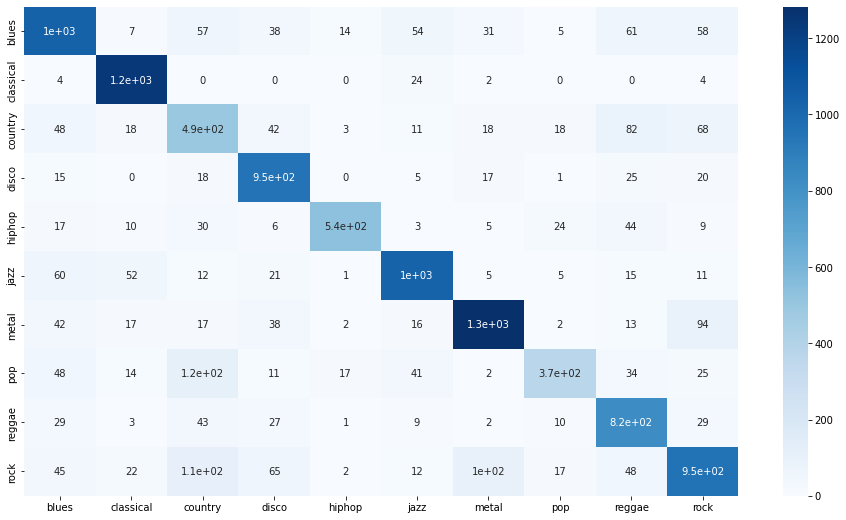

In [43]:
# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
# plt.savefig("conf matrix")

In [44]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(estimator=xgb, random_state=1)
# perm.fit(X_test, y_test)

# eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

In [45]:
y_true = y_test
y_pred = knn.predict(X_test)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = le.inverse_transform(labels)

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(10929,) (10929,)
              precision    recall  f1-score   support

       blues       0.77      0.76      0.77      1360
   classical       0.90      0.97      0.93      1274
     country       0.55      0.62      0.58       802
       disco       0.79      0.90      0.84      1051
      hiphop       0.93      0.78      0.85       683
        jazz       0.85      0.85      0.85      1210
       metal       0.88      0.84      0.86      1524
         pop       0.82      0.55      0.66       677
      reggae       0.72      0.84      0.78       975
        rock       0.75      0.69      0.72      1373

    accuracy                           0.80     10929
   macro avg       0.80      0.78      0.78     10929
weighted avg       0.80      0.80      0.80     10929

